In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from matplotlib.ticker import MaxNLocator, LogLocator, MultipleLocator, FuncFormatter

import lmfit
from lmfit import Parameters, minimize, fit_report

%matplotlib inline

# Load the CSV files
file1 = "/Users/asm18/Downloads/gp-6.csv"  # Replace with the actual file path
file2 = "/Users/asm18/Downloads/gpp-5.csv"  # Replace with the actual file path
output_file = "/Users/asm18/Downloads/interpolated_data_updated.xlsx"

# Read the first two columns
df1 = pd.read_csv(file1, usecols=[0, 1], header=None, names=["X1", "Y1"])
df2 = pd.read_csv(file2, usecols=[0, 1], header=None, names=["X2", "Y2"])

# Extract values
X1, Y1 = df1["X1"].values, df1["Y1"].values
X2, Y2 = df2["X2"].values, df2["Y2"].values

Y1 = Y1 * 1E+6
Y2 = Y2 * 1E+6

interp_func = interp1d(np.log(X1), np.log(Y1), kind="linear", fill_value="extrapolate")
Y1_interpolated = np.exp(interp_func(np.log(X1)))

interp_func = interp1d(np.log(X2), np.log(Y2), kind="linear", fill_value="extrapolate")
Y2_interpolated = np.exp(interp_func(np.log(X1)))

export_df = pd.DataFrame({"Strain": X1, "Storage modulus": Y1_interpolated, "Loss modulus": Y2_interpolated})
export_df.to_excel(output_file, index=False)

## Generating spectrum and moduli using the mBSW spectrum given below

$$ H(\tau) = e^{-\left(\frac{\tau}{\tau_{\text{max}}}\right)^{\beta}} \left[ H_e \left(\frac{\tau}{\tau_{\text{max}}}\right)^{n_e} + H_g \left(\frac{\tau}{\tau_e}\right)^{-n_g} \right] $$

In [2]:
def compute_rheological_properties(tau, time, omega, bsw_params, at1=1, at2=1):
    r"""
    Compute relaxation modulus (g_relax), storage modulus (gp_model), and loss modulus (gpp_model)
    given tau, time, omega, and BSW parameters.

    The relaxation spectrum \( H(\tau) \) is given by:

    .. math::
        H(\tau) = e^{-\left(\frac{\tau}{\tau_{\text{max}}}\right)^{\beta}}
        \left[ H_e \left(\frac{\tau}{\tau_{\text{max}}}\right)^{n_e} + 
        H_g \left(\frac{\tau}{\tau_e}\right)^{-n_g} \right]

    Parameters:
    - tau: array of relaxation times
    - time: array of time values
    - omega: array of angular frequencies
    - bsw_params: list of BSW model parameters
    - at1, at2: shift factors for \(\tau_e\) and \(\tau_{\text{max}}\)

    Returns:
    - g_relax: Relaxation modulus array
    - gp_model: Storage modulus array
    - gpp_model: Loss modulus array
    - omega: Angular frequency array (for plotting)
    - time: Time array (for plotting)
    """

    # Compute shifted tau values
    tau_e_shifted = bsw_params[2] * at1
    tau_max_shifted = bsw_params[5] * at1

    # Compute flow contribution
    htau_flow = np.exp(-(np.power(tau / tau_max_shifted, bsw_params[6]))) * \
                (bsw_params[3] * np.power(tau / tau_max_shifted, bsw_params[4]))

    # Compute glassy contribution
    tau_e_shifted = bsw_params[2] * at2
    tau_max_shifted = bsw_params[5] * at2

    htau_glassy = np.exp(-(np.power(tau / tau_max_shifted, bsw_params[6]))) * \
                  (bsw_params[0] * (np.power(tau / tau_e_shifted, -bsw_params[1])))

    # Total relaxation spectrum
    htau_total = htau_flow + htau_glassy
    gi = htau_total / tau

    # Compute relaxation modulus g_relax
    tau_time = -time[:, np.newaxis] / tau[np.newaxis, :]
    g_tau_time = np.exp(tau_time) * gi
    g_relax = np.sum(np.diff(tau) * (g_tau_time[:, :-1] + g_tau_time[:, 1:]) / 2, axis=1)

    # Compute storage modulus (Gp) and loss modulus (Gpp)
    tau_omega = omega[:, np.newaxis] * tau[np.newaxis, :]
    inv_plus_squared = 1 / (1 + tau_omega**2)

    gp_tau_omega = (tau_omega**2) * inv_plus_squared * gi
    gpp_tau_omega = (tau_omega**1) * inv_plus_squared * gi

    gp_model = np.sum(np.diff(tau) * (gp_tau_omega[:, :-1] + gp_tau_omega[:, 1:]) / 2, axis=1)
    gpp_model = np.sum(np.diff(tau) * (gpp_tau_omega[:, :-1] + gpp_tau_omega[:, 1:]) / 2, axis=1)

    return htau_total, g_relax, gp_model, gpp_model, time, omega

### Fitting code
Can be commented out but remove bsw params from the loop later on

In [3]:
def residual_fcn(params, omega, gp_exp, gpp_exp, tau, time):
    
    full_params = np.array([params[p].value for p in params])
    htau, g_relax, gp_model, gpp_model, time, omega = compute_rheological_properties(tau, time, omega, full_params)
    
    nan_locations = np.isnan(gp_model)
    nan_indices = np.where(nan_locations)[0]
    if np.any(nan_locations):
        print(f"nan found in {gp_model} at freq in {omega[nan_indices]} with the params {params}")
    
    resid_gp = ((gp_exp - gp_model) / ((gp_exp + 1E-8)))
    resid_gpp = ((gpp_exp - gpp_model) / ((gpp_exp + 1E-8)))
    
    return np.hstack((resid_gp, resid_gpp)).flatten()
    
time = np.logspace(-9, 6, 100000)
tau = np.logspace(np.log10(5E-5), +8, num=1000, base=10)

fit_params = Parameters()

fit_params.add(f"Hg",       value=5.0E+5,   vary=True,      min=5.0E+3,     max=5.0E+6)
fit_params.add(f"ng",       value=0.67,     vary=True,      min=0.0,        max=1.0)
fit_params.add(f"tau_e",    value=0.86,     vary=True,      min=0.0,        max=100.0)
fit_params.add(f"He",       value=2.0E+5,   vary=True,      min=5.0E+4,     max=5.0E+6)
fit_params.add(f"ne",       value=0.3,      vary=True,      min=0.0,        max=1.0)
fit_params.add(f"tau_max",  value=9.0E+5,   vary=True,      min=5.0E+4,     max=5.0E+6)
fit_params.add(f"beta",     value=2.0E-0,   vary=True,      min=0.0,        max=5.0)

minimizer = lmfit.Minimizer(
                                residual_fcn, fit_params, 
                                fcn_args=(
                                        X1, Y1_interpolated, Y2_interpolated, tau, time,
                                        )
                                )

out = minimizer.minimize(
                                method="leastsq",
                                params=fit_params,
                                ftol=1e-12,         
                                xtol=1e-12,         
                                gtol=1e-12,         
                                max_nfev=10000,     
                            )

bsw_params = np.array([out.params[name].value for name in out.params])

In [4]:
print(bsw_params)

[4.87057924e+05 9.03788898e-01 8.51787000e-02 2.72615463e+05
 2.77521233e-01 1.12787422e+06 5.00000000e+00]


### MAIN - Calculating the spectrum and plotting

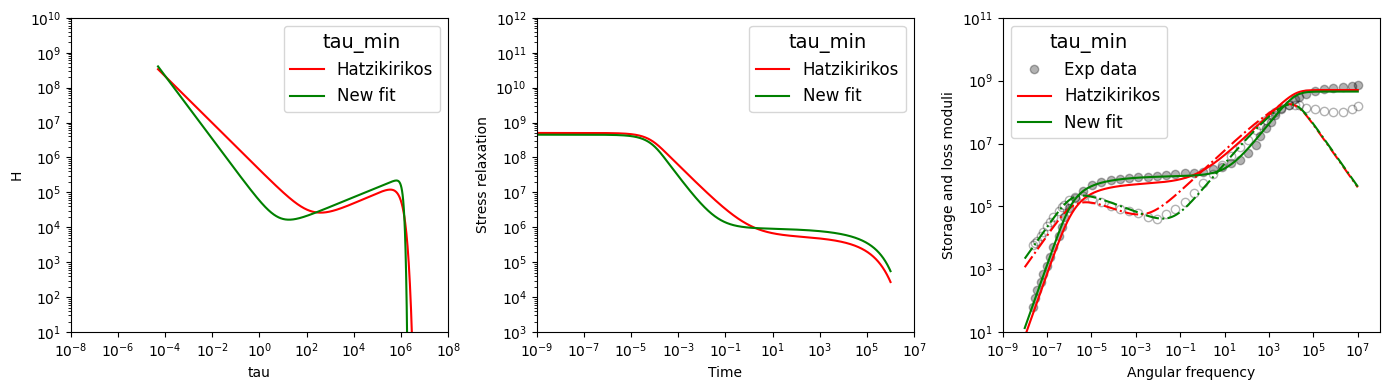

In [6]:
time = np.logspace(-9, 6, 100000)
omega = np.logspace(-8, 7, 10000)

paper_bsw_params = [
    4.9E+5,  # Hg
    6.7E-1,  # n_g
    8.6E-1,  # tau_e
    1.86E+5, # He
    3.0E-1,  # n_e
    9.0E+5,  # tau_max
    2.0E+0   # beta
]

tau_min_values = [5E-5]
colors = ['r', 'g', 'b']
# labels = [rf"$10^{{{int(np.log10(val))}}}$" for val in tau_min_values]
labels = ["Hatzikirikos", "New fit"]

fig, axes, *_ = plt.subplots(1, 3, figsize=(5*3-1, 4))
axes[2].loglog(X1, Y1_interpolated, label="Exp data", marker="o", linestyle=" ", 
               markersize=6, markerfacecolor='black', markeredgecolor='black', alpha=0.3)
axes[2].loglog(X1, Y2_interpolated, marker="o", linestyle=" ", 
               markersize=6, markerfacecolor='none', markeredgecolor='black', alpha=0.3) 

for i, tau_min in enumerate(tau_min_values):
    for j, params in enumerate([paper_bsw_params, bsw_params]):
        tau = np.logspace(np.log10(tau_min), +8, num=1000, base=10)
        htau, g_relax, gp_model, gpp_model, time, omega = compute_rheological_properties(tau, time, omega, params)
        
        axes[0].loglog(tau, htau, linestyle="-", color=colors[j], label=labels[j])
        # axes[0].loglog(tau, htau/tau, linestyle="-", color='k', label=labels[j])
        axes[1].loglog(time, g_relax, linestyle="-", color=colors[j], label=labels[j])
        axes[2].loglog(omega, gp_model, linestyle="-", color=colors[j], label=labels[j])
        axes[2].loglog(omega, gpp_model, linestyle="-.", color=colors[j])

# region PLOT SETTINGS
axes[0].set_xlim([1E-8, 1E+8])
axes[0].set_ylim([1E+1, 1E+10])

axes[1].set_xlim([1E-9, 1E+7])
axes[1].set_ylim([1E+3, 1E+12])

axes[2].set_xlim([1E-9, 1E+8])
axes[2].set_ylim([1E+1, 1E+11])

axes[0].set_xlabel("tau")
axes[0].set_ylabel("H")
axes[0].legend(title=r"tau_min", fontsize=12, title_fontsize=14)

axes[1].set_xlabel("Time")
axes[1].set_ylabel("Stress relaxation")
axes[1].legend(title=r"tau_min", fontsize=12, title_fontsize=14)

axes[2].set_xlabel("Angular frequency")
axes[2].set_ylabel("Storage and loss moduli")
axes[2].legend(title=r"tau_min", fontsize=12, title_fontsize=14)

for ax in axes:
    ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
    ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
    ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))
    ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))

plt.tight_layout()
plt.show()
# endregion 